In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('../data/sentences_with_sentiment.xlsx')
df.head(10)

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0
5,6,Taking into account the intrinsic limitation o...,1,0,0
6,7,This medicinal product has been authorised und...,0,0,1
7,8,This means that further evidence on this medic...,0,1,0
8,9,The European Medicines Agency will review new ...,0,0,1
9,10,The CHMP considers the following measures nece...,0,1,0


In [3]:
len(df)

266

In [4]:
df["Sentence"].apply(lambda s: len(s)).describe()

count    266.000000
mean     161.233083
std       77.709123
min       39.000000
25%      105.000000
50%      139.500000
75%      206.500000
max      431.000000
Name: Sentence, dtype: float64

In [5]:
df["Sentence"].apply(lambda s: len(s.split())).describe()

count    266.000000
mean      24.533835
std       11.731942
min        7.000000
25%       16.000000
50%       22.000000
75%       30.750000
max       63.000000
Name: Sentence, dtype: float64

In [6]:
df['Polarity'] = df['Positive'] - df['Negative'] + 1

Text(0, 0.5, 'Number of sentences')

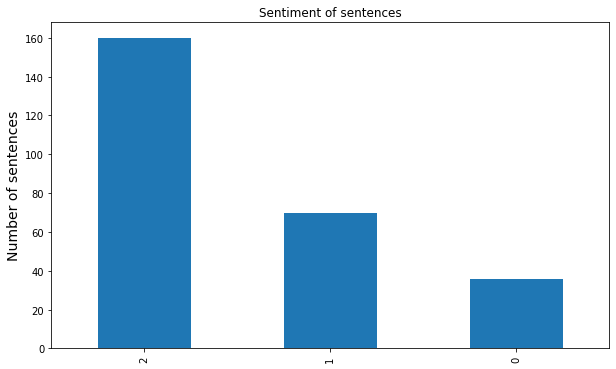

In [7]:
ax = df['Polarity'].value_counts().plot(kind='bar', figsize=(10, 6))
ax.set_title('Sentiment of sentences')
ax.set_ylabel('Number of sentences', fontsize=14)

In [8]:
from IPython.core.display import HTML
display(HTML(df[df['Polarity'] == 0].sample(n=10, random_state=42)[['Sentence']].to_html()))

,Sentence
264,"There was no general indication of VOX-associated transaminitis, as has been seen with other NS3/4A inhibitors; however, two cases associated with concomitant ethinyl estradiol among a total of 29 objects exposed, which makes co-administration quite questionable."
97,"Although toxicity appears to be manageable with the intended combination, an onset of more frequent or severe toxicity may occur in a larger database and/or at longer term."
170,"ACR20 results per visit showed significant differences which may be interpreted as indicating a faster onset of effect for ABP 501, which could question similarity."
187,the MAH should conduct and submit the results of the
100,The CHMP considers the following measures necessary to address issues related to safety
188,"• PAES: In order to evaluate the long term efficacy and safety of Nusinersen in pre-symptomatic patients with spinal muscular atrophy, the MAH should conduct and submit the results of the Phase 2, open-label study (NURTURE (SM201))"
144,"Although dataset of AFL patients has been updated, data are still considered very limited to reach firm conclusion about safety proflie."
96,"However, precaution is warranted given a small size of safety database, a limited information on long-term toxicity, and a limited data on PK/PD interactions together with indication on potential for worsening toxicity for VEGFRi -mTOR inhibitor combinations in general."
40,"Only 3 pivotal randomized double-blind multicentre placebo controlled studies (Parsons and Mulholland 1987, Mulholland et al 1990 and Parsons et al 1993) among the 6 pivotal studies met their primary endpoint “GRA” and some secondary endpoints such as pain."
101,Study 307 is requested to further characterise the safety and tolerability profile of the combination therapy and further contribute to knowledge on PK and PK/PD of lenvatinib and everolimus and their PK and PD interactions.


mean word counts:
positive 24.1875
neutral 24.67142857142857
negative: 25.805555555555557


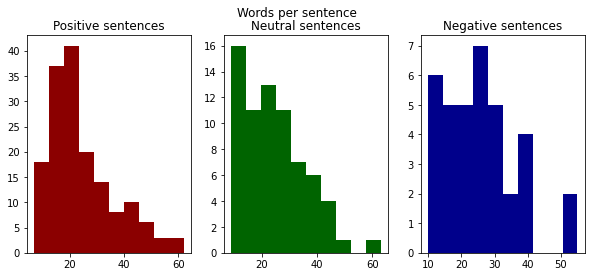

In [9]:
# Word counts 
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))
print("mean word counts:")
print("positive", df[df['Polarity']==2]['word_count'].mean()) 
print("neutral", df[df['Polarity']==1]['word_count'].mean()) 
print("negative:", df[df['Polarity']==0]['word_count'].mean()) 

# Plot word counts in different polarity groups
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(10,4))
ax1.hist(df[df['Polarity']==2]['word_count'],color='darkred')
ax1.set_title('Positive sentences')
ax2.hist(df[df['Polarity']==1]['word_count'],color='darkgreen')
ax2.set_title('Neutral sentences')
ax3.hist(df[df['Polarity']==0]['word_count'],color='darkblue')
ax3.set_title('Negative sentences')

fig.suptitle('Words per sentence')
plt.show()

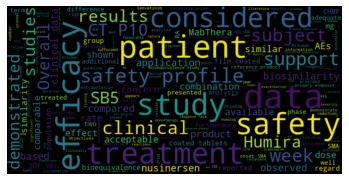

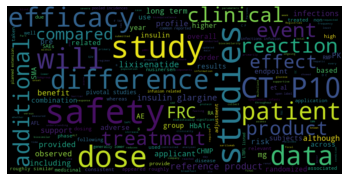

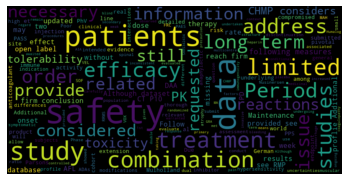

<Figure size 432x288 with 0 Axes>

In [10]:
from wordcloud import WordCloud

def generateWordCloud(corpus: str, cmap: str) -> WordCloud:
    """
    Return a Word Cloud object generated from the corpus and color map parameter.
    """
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate(corpus)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

    return wordcloud
 
# Generate the Word Clouds for each of the polarities
pos_corpus = " ".join(sentence for sentence in df[df['Polarity'] == 2]["Sentence"])
neu_corpus = " ".join(sentence for sentence in df[df['Polarity'] == 1]["Sentence"])
neg_corpus = " ".join(sentence for sentence in df[df['Polarity'] == 0]["Sentence"])

generateWordCloud(corpus = pos_corpus, cmap = 'viridis').to_file('positive.png')
generateWordCloud(corpus = neu_corpus, cmap = 'viridis').to_file('neutral.png')
generateWordCloud(corpus = neg_corpus, cmap = 'viridis').to_file('negative.png')


In [12]:
# Lets try some simple classifiers 
# Text pre-processing
import re, string
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word embedding
import gensim
from gensim.models import Word2Vec, KeyedVectors 

[nltk_data] Downloading package punkt to /Users/shm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/shm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Baseline Classifier
Befor we do anything it is always a good idea to establish a baseline. An obvious baseline model is a majority class classifier, which in case would always predict positive sentiment, leading to accuracy of:


In [14]:
len(df[df["Polarity"]==2])/len(df)

0.6015037593984962

### Prepare dataset

In [15]:
wordnet_lemmatizer = WordNetLemmatizer()

In [16]:
def lemmatize(text):
    processed_list = [wordnet_lemmatizer.lemmatize(i,j[0].lower()) \
     if j[0].lower() in ['a','n','v'] else wordnet_lemmatizer.lemmatize(i) for i,j in pos_tag(word_tokenize(text))]
    return ' '.join(processed_list)

In [17]:
lemmatize("this is an interesting test")

'this be an interesting test'

In [18]:
print(stopwords.words('english')[:50])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']


In [19]:
stopword_set = set(stopwords.words('english'))
modals_set = {'can', 'could', 'may', 'might', 'must', 'will', 'would', 'should', 'not'}

print(modals_set.intersection(stopword_set))
# for this application we do not want to remove modals as they might carry polarity signals
stopword_set.difference_update(modals_set)


{'can', 'not', 'will', 'should'}


In [20]:
from typing import Set
def remove_stopwords(text:str, stopwords:Set) -> str:
    processed_list = [word for word in text.split() if word not in stopwords] 
    return ' '.join(processed_list)

In [21]:
df["Sentence_swf"] = df["Sentence"].apply(lambda s: remove_stopwords(str.lower(s), stopword_set))

In [22]:
df.head()

,ID,Sentence,Positive,Negative,Neutral,Polarity,word_count,Sentence_swf
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,23,results 2nd line treatment show orr 33% patien...
1,2,The long duration of response and high durable...,1,0,0,2,24,long duration response high durable response r...
2,3,The median OS time in the updated results exce...,0,0,1,1,11,median os time updated results exceeded 1 year
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,23,"therefore, clinical benefit 2nd line treatment..."
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,41,"data provided 1st line, although preliminary, ..."


In [23]:
df["Sentence_swf_lemma"] = df["Sentence_swf"].apply(lambda s: lemmatize(s))

In [24]:
df.head()

,ID,Sentence,Positive,Negative,Neutral,Polarity,word_count,Sentence_swf,Sentence_swf_lemma
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,23,results 2nd line treatment show orr 33% patien...,result 2nd line treatment show orr 33 % patien...
1,2,The long duration of response and high durable...,1,0,0,2,24,long duration response high durable response r...,long duration response high durable response r...
2,3,The median OS time in the updated results exce...,0,0,1,1,11,median os time updated results exceeded 1 year,median o time updated result exceed 1 year
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,23,"therefore, clinical benefit 2nd line treatment...","therefore , clinical benefit 2nd line treatmen..."
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,41,"data provided 1st line, although preliminary, ...","data provide 1st line , although preliminary ,..."


In [26]:
global stopword_set 
stopword_set = set(stopwords.words('english'))
modals_set = {'can', 'could', 'may', 'might', 'must', 'will', 'would', 'should', 'not'}
# for this application we do not want to remove modals as they might carry polarity signals
stopword_set.difference_update(modals_set)


def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except the modals and not
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = remove_stopwords(s, stopword_set)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    # Uncomment to lemmatize as well
#     s = lemmatize(s) 
    
    return s

In [27]:
df["Sentence_swf"] = df["Sentence"].apply(lambda s: text_preprocessing(str.lower(s)))

In [28]:
df

,ID,Sentence,Positive,Negative,Neutral,Polarity,word_count,Sentence_swf,Sentence_swf_lemma
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,23,results 2nd line treatment show orr 33 patient...,result 2nd line treatment show orr 33 % patien...
1,2,The long duration of response and high durable...,1,0,0,2,24,long duration response high durable response r...,long duration response high durable response r...
2,3,The median OS time in the updated results exce...,0,0,1,1,11,median os time updated results exceeded 1 year,median o time updated result exceed 1 year
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,23,therefore clinical benefit 2nd line treatment ...,"therefore , clinical benefit 2nd line treatmen..."
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,41,data provided 1st line although preliminary sh...,"data provide 1st line , although preliminary ,..."
...,...,...,...,...,...,...,...,...,...
261,262,"Compared to SOF/VEL and placebo, there were si...",1,0,0,2,27,compared sof vel placebo similar rates aes ove...,"compare sof/vel placebo , similar rate aes ove..."
262,263,Other potentially related AE’s including decre...,0,0,1,1,12,potentially related ae including decreased app...,potentially related ae ’ s include decrease ap...
263,264,No treatment-related SAE was reported and only...,1,0,0,2,26,treatment related sae reported one subject 0 1...,treatment-related sae report one subject ( 0.1...
264,265,There was no general indication of VOX-associa...,0,1,0,0,36,general indication vox associated transaminiti...,general indication vox-associated transaminiti...


To start with we just go with a stratified train test split, for a more realistic evaluation we will use k-fold cross-validation later on

In [29]:
from sklearn.model_selection import train_test_split
X = df["Sentence_swf"]
y = df["Polarity"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Lets turn text to vectors: count vectorizer

In [32]:
# Convert X_train to vectors
# Parameter election
ngram_range = (1,2)
# min_df = 10
# max_df = 1.
max_features = 1000
count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_cv = count_vectorizer.fit_transform(X_train)
# Only transform X_val 
X_val_cv = count_vectorizer.transform(X_val) 

print(X_train_cv.shape)
print(X_val_cv.shape)

(186, 1000)
(80, 1000)


In [43]:
ngram_range = (1,3)
# min_df = 10
# max_df = 1.
max_features = 1000
binary=True
smooth_idf=False
tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, binary=binary, smooth_idf=smooth_idf, max_features=max_features)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Only transform X_val 
X_val_tfidf = tfidf_vectorizer.transform(X_val)


print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(186, 1000)
(80, 1000)


### Build classifiers

In [39]:
print(X_train_tfidf)

  (0, 567)	0.13914692592902336
  (0, 288)	0.13914692592902336
  (0, 23)	0.1474185387977748
  (0, 430)	0.1474185387977748
  (0, 597)	0.1474185387977748
  (0, 485)	0.1474185387977748
  (0, 283)	0.1474185387977748
  (0, 293)	0.1474185387977748
  (0, 348)	0.1474185387977748
  (0, 126)	0.1474185387977748
  (0, 33)	0.1474185387977748
  (0, 346)	0.1474185387977748
  (0, 125)	0.1474185387977748
  (0, 435)	0.1474185387977748
  (0, 351)	0.1474185387977748
  (0, 128)	0.1474185387977748
  (0, 536)	0.1474185387977748
  (0, 194)	0.1474185387977748
  (0, 399)	0.1474185387977748
  (0, 492)	0.11280116811139523
  (0, 566)	0.13914692592902336
  (0, 287)	0.11280116811139523
  (0, 22)	0.1474185387977748
  (0, 429)	0.1474185387977748
  (0, 596)	0.1474185387977748
  :	:
  (184, 237)	0.38685096350890386
  (184, 105)	0.2816827164932061
  (184, 496)	0.3584999925168779
  (184, 577)	0.33838465847725796
  (184, 412)	0.3227819932321904
  (184, 584)	0.2743156882005446
  (184, 558)	0.23721304767099285
  (184, 491)	0.

In [44]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.80      0.19      0.31        21
           2       0.66      1.00      0.79        48

    accuracy                           0.68        80
   macro avg       0.82      0.46      0.47        80
weighted avg       0.74      0.68      0.60        80

Confusion Matrix:
 [[ 2  1  8]
 [ 0  4 17]
 [ 0  0 48]]


In [42]:
nb_cv = MultinomialNB()
nb_cv.fit(X_train_cv, y_train)  #model

#Predict y value for test dataset
y_predict = nb_cv.predict(X_val_cv)
y_prob = nb_cv.predict_proba(X_val_cv)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 

              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.53      0.48      0.50        21
           2       0.78      0.90      0.83        48

    accuracy                           0.71        80
   macro avg       0.66      0.58      0.60        80
weighted avg       0.70      0.71      0.70        80

Confusion Matrix:
 [[ 4  5  2]
 [ 1 10 10]
 [ 1  4 43]]


Lopgistic Regression

In [47]:
from pprint import pprint

lr_0 = LogisticRegression(random_state = 42)
print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [48]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 10, num = 50)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.3020408163265306,
       0.5040816326530613,
       0.7061224489795919,
       0.9081632653061225,
       1.1102040816326533,
       1.3122448979591839,
       1.5142857142857145,
       1.716326530612245,
       1.9183673469387756,
       2.1204081632653065,
       2.322448979591837,
       2.5244897959183676,
       2.7265306122448982,
       2.928571428571429,
       3.1306122448979594,
       3.33265306122449,
       3.5346938775510206,
       3.736734693877551,
       3.938775510204082,
       4.140816326530612,
       4.3428571428571425,
       4.544897959183674,
       4.746938775510204,
       4.948979591836735,
       5.151020408163265,
       5.353061224489796,
       5.555102040816326,
       5.757142857142857,
       5.959183673469387,
       6.161224489795918,
       6.3632653061224485,
       6.5653061224489795,
       6.7673469387755105,
       6.969387755102041,
       7.171428571428572,
       7.373469387755102,
       7.575510204081633,
       7.7

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# First create base model to tune
lrc = LogisticRegression(random_state=42)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model

/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.3020408163265306,
                                              0.5040816326530613,
                                              0.7061224489795919,
                                              0.9081632653061225,
                                              1.1102040816326533,
                                              1.3122448979591839,
                                              1.5142857142857145,
                                              1.716326530612245,
                                              1.9183673469387756,
                                              2.1204081632653065,
                                              2.322448979591837,
                                              2.5244897959183676,
                                              2.726530612244...
                                       

In [61]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 6.7673469387755105}

The mean accuracy of a model with these hyperparameters is:
0.6881720430107526


In [63]:
best_lrc = random_search.best_estimator_
lrc_pred = best_lrc.predict(X_val_tfidf)

In [64]:
# Classification report
print("Classification report")
print(classification_report(y_val,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        11
           1       0.50      0.48      0.49        21
           2       0.75      0.79      0.77        48

    accuracy                           0.65        80
   macro avg       0.56      0.54      0.55        80
weighted avg       0.64      0.65      0.64        80



Embeddings? probably not as Tf/Idf did worse than count vectorizer

In [65]:
word2vec_path = '../models/bio_embedding_extrinsic'
w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [66]:
w2v_model.vector_size

200

In [67]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = word2vec.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0) # for oov 
            for words in X
        ])


In [68]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok = [nltk.word_tokenize(i) for i in X_val]      #for word2vec

In [69]:
# Fit and transform
mev = MeanEmbeddingVectorizer(w2v_model)
X_train_w2v = mev.transform(X_train_tok)
X_val_w2v = mev.transform(X_val_tok)

In [71]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v= LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_w2v)
y_prob = lr_w2v.predict_proba(X_val_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 

              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.43      0.43      0.43        21
           2       0.75      0.88      0.81        48

    accuracy                           0.66        80
   macro avg       0.62      0.50      0.51        80
weighted avg       0.65      0.66      0.64        80

Confusion Matrix:
 [[ 2  6  3]
 [ 1  9 11]
 [ 0  6 42]]


In [72]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# First create base model to tune
lrc = LogisticRegression(random_state=42)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train_w2v, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model

/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_

/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/linear_model

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.3020408163265306,
                                              0.5040816326530613,
                                              0.7061224489795919,
                                              0.9081632653061225,
                                              1.1102040816326533,
                                              1.3122448979591839,
                                              1.5142857142857145,
                                              1.716326530612245,
                                              1.9183673469387756,
                                              2.1204081632653065,
                                              2.322448979591837,
                                              2.5244897959183676,
                                              2.726530612244...
                                       

In [73]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 5.757142857142857}

The mean accuracy of a model with these hyperparameters is:
0.6505376344086021


In [103]:
# nb_w2v = MultinomialNB()
# nb_w2v.fit(X_train_w2v, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.80      0.19      0.31        21
           2       0.66      1.00      0.79        48

    accuracy                           0.68        80
   macro avg       0.82      0.46      0.47        80
weighted avg       0.74      0.68      0.60        80

Confusion Matrix:
 [[ 2  1  8]
 [ 0  4 17]
 [ 0  0 48]]


In [106]:
# Naive Bayes has only one parameter alpha
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
grid_search= GridSearchCV(nb_tfidf, parameters)
grid_search.fit(X_train_tfidf,y_train)


GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)})

In [107]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'alpha': 0.0001}

The mean accuracy of a model with these hyperparameters is:
0.6726884779516359


Are we overfitting?

In [109]:
y_pred_train = grid_search.best_estimator_.predict(X_train_tfidf)
accuracy_score(y_train, y_pred_train)

0.9946236559139785

Not enough data, no point to try more complex models or try to find optimal hyper parameteres

With pipelines we can stack different preprocessing, vectorization, and classification models:

In [112]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
data_x = df["Sentence_swf"].to_list()
data_y = df["Polarity"].to_list()
clf = make_pipeline(MeanEmbeddingVectorizer(w2v_model), SVC(kernel='linear', probability=True))
scores = cross_validate(clf, data_x, data_y, scoring=['accuracy'], cv=5, return_train_score=False)
print(scores) 

{'fit_time': array([0.09710908, 0.07188916, 0.07589221, 0.08111   , 0.07233   ]), 'score_time': array([0.01862288, 0.01577306, 0.01340699, 0.0183773 , 0.01159501]), 'test_accuracy': array([0.59259259, 0.60377358, 0.60377358, 0.60377358, 0.60377358])}


One more thing before we look at data augmentation:
How does an off the shelf sentiment analyzer do for our data?

In [94]:
# Lets see how a off the shelf sentiment analyzer does
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt.get('compound')

In [95]:
text = "The bioequivalence study appears to have been well conducted."
sentiment_scores(text)

0.2732

In [96]:
df["vader_snt"] = df['Sentence'].apply(sentiment_scores)

In [97]:
df

,ID,Sentence,Positive,Negative,Neutral,Polarity,word_count,Sentence_swf,Sentence_swf_lemma,vader_snt
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,23,results 2nd line treatment show orr 33 patient...,result 2nd line treatment show orr 33 % patien...,0.0000
1,2,The long duration of response and high durable...,1,0,0,2,24,long duration response high durable response r...,long duration response high durable response r...,0.0000
2,3,The median OS time in the updated results exce...,0,0,1,1,11,median os time updated results exceeded 1 year,median o time updated result exceed 1 year,0.0000
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,23,therefore clinical benefit 2nd line treatment ...,"therefore , clinical benefit 2nd line treatmen...",0.7269
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,41,data provided 1st line although preliminary sh...,"data provide 1st line , although preliminary ,...",0.0000
...,...,...,...,...,...,...,...,...,...,...
261,262,"Compared to SOF/VEL and placebo, there were si...",1,0,0,2,27,compared sof vel placebo similar rates aes ove...,"compare sof/vel placebo , similar rate aes ove...",0.2732
262,263,Other potentially related AE’s including decre...,0,0,1,1,12,potentially related ae including decreased app...,potentially related ae ’ s include decrease ap...,-0.4019
263,264,No treatment-related SAE was reported and only...,1,0,0,2,26,treatment related sae reported one subject 0 1...,treatment-related sae report one subject ( 0.1...,-0.2960
264,265,There was no general indication of VOX-associa...,0,1,0,0,36,general indication vox associated transaminiti...,general indication vox-associated transaminiti...,-0.7178


It does not seem to correlate well with our scores